### Calculates price-equilibrium in the market for blockchain records,  with and without the lightning network.

###  Includes symbolic calculations and plots for specific parameter values.

In [55]:
import numpy as np
import sympy
sympy.init_printing(use_unicode=True)
from sympy import *
from sympy.solvers import solve
from IPython.display import display
from typing import Callable
from sympy.utilities.lambdify import lambdify, implemented_function

%matplotlib inline
import matplotlib.pyplot as plt

def simplified(exp, title=None):
    simp = simplify(exp)
    if simplified.LOG:
        if title: display(title,simp)
        else: display(simp)
    return simp
simplified.LOG = True

def firstOrderCondition(exp, var):
    diffExp = simplified(diff(exp, var))
    solutions = solve(diffExp, var)
    if firstOrderCondition.LOG:
        display(solutions)
    return solutions
firstOrderCondition.LOG = True
  
class Result(object):   # a class for holding results of calculations
    def __repr__(self): return self.__dict__.__repr__()
    def display(self):
        for k,v in sorted(self.__dict__.items()):
            display(k,v)
    def subs(self, params):
        ans = Result()
        for k,v in sorted(self.__dict__.items()):
            if hasattr(v,"subs"):
                ans.__dict__[k] = v.subs(params)
            else:
                ans.__dict__[k] = v
        return ans

# Symbolic calculations

In [2]:
a,p,r,b,vmax,zmin,zmax,beta = symbols('a \\phi r z v_{\max} z_{\min} z_{\max} \\beta', positive=True,finite=True,real=True)
w,T,D,L,n,Supply = symbols('w T \\Delta \\ell n \\tau', positive=True,finite=True,real=True)
D,Supply,p

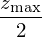

In [3]:
def exactCostPerDay(T):
    return (a*p + w*b*( (1+r)**T - 1 )) / T

def approxCostPerDay(T):
    return a*p/T + w*b*r

def symmetricLifetime(w):
    return w**2/4/L

def asymmetricLifetime(w):
    return w / D


uniformPDF = Piecewise( (1 / zmax , b<zmax), (0, True) )
powerlawPDF =  Piecewise( (0 , b<zmin), (zmin / b**2, True) )

display(sympy.integrate(uniformPDF, (b, 0, sympy.oo)))  # should be 1
display(sympy.integrate(powerlawPDF, (b, 0, sympy.oo))) # should be 1
display(sympy.integrate(b*uniformPDF, (b, 0, sympy.oo)))  # should be zmax/2
display(sympy.integrate(b*powerlawPDF, (b, 0, sympy.oo))) # should be infinity!

In [4]:
params = {
    L: 10,           # total transfers per day 
    D: 6,            # delta transfers per day 
    beta: 0.01,      # value / transfer-size
    r: 4/100/365,    # interest rate per day
    a: 1.1,          # records per reset tx
    Supply: 288000,  # records per day
    zmin: 0.001,     # min transfer size (for power law distribution)
    zmax: 1,         # max transfer size (for uniform distribution)
}

In [5]:
def calculateLifetime(costPerDay:Callable, channelLifetime:Callable, wSolutionIndex:int):
    T = simplified(channelLifetime(w), "T")
    CPD = simplified(costPerDay(T), "CPD")
    optimal = Result()
    optimal.w = simplified(firstOrderCondition(CPD,w)[wSolutionIndex], "Optimal channel funding (w)")
    optimal.T   = simplified(T.subs(w,optimal.w), "optimal channel lifetime (T)")
    optimal.CPD = simplified(CPD.subs(w,optimal.w), "Cost-per-day") 
    optimal.RPD = simplified(a / optimal.T, "Potential records per day") 
    optimal.C   =   simplified(optimal.CPD*optimal.T, "Cost between resets") 
    optimal.V   =   simplified(optimal.T*L*beta*b, "Value between resets")
    optimal.VCR1 = 1
    optimal.VCR2 = simplified(optimal.V / optimal.C, "Value/Cost Ratio of lightning")
    optimal.VCR3 = simplified(beta*b / p, "Value/Cost Ratio of blockchain")
    optimal.b12  = simplified(solve(optimal.VCR1-optimal.VCR2,b)[0],"b below which an agent prefers nop to lightning")
    optimal.b13  = simplified(solve(optimal.VCR1-optimal.VCR3,b)[0],"b below which an agent prefers nop to blockchain")
    optimal.b23  = simplified(solve(optimal.VCR2-optimal.VCR3,b)[0],"b below which an agent prefers lightning to blockchain")

    # Calculate threshold prices. This part is relevant only for uniform valuations.
    optimal.p12 = simplified(solve(optimal.b12-zmax,p)[0],"price above which all agents prefer nop to lightning")
    optimal.p13 = simplified(solve(optimal.b13-zmax,p)[0],"price above which all agents prefer nop to blockchain")
    optimal.p23 = simplified(solve(optimal.b23-zmax,p)[0],"price above which all agents prefer lightning to blockchain")

    
    # substitute the numeric params:
    numeric = optimal.subs(params)
    numeric.b23 = numeric.b23.evalf()
    numeric.p23 = numeric.p23.evalf()
    return (optimal,numeric)

In [6]:
simplified.LOG = False
firstOrderCondition.LOG = False
(asymmetricSymbolic,asymmetricNumeric) = calculateLifetime(approxCostPerDay,asymmetricLifetime,wSolutionIndex=0)

'C'

'CPD'

'RPD'

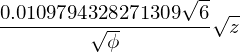

'T'

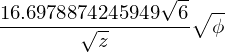

'V'

'VCR1'

'VCR2'

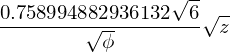

'VCR3'

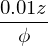

'b12'

'b13'

'b23'

'p12'

'p13'

'p23'

'w'

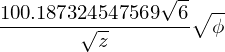

In [7]:
#asymmetricSymbolic.display()
asymmetricNumeric.display()

In [8]:
simplified.LOG = False
firstOrderCondition.LOG = False
(symmetricSymbolic,symmetricNumeric) = calculateLifetime(approxCostPerDay,symmetricLifetime,wSolutionIndex=0)

'C'

'CPD'

'RPD'

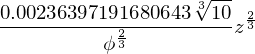

'T'

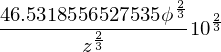

'V'

'VCR1'

'VCR2'

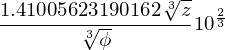

'VCR3'

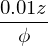

'b12'

'b13'

'b23'

'p12'

'p13'

'p23'

'w'

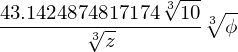

In [9]:
symmetricNumeric.display()

# Demand curves

'demand with lightning'

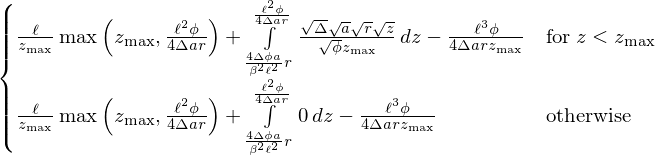

'demand without lightning'

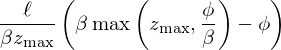

'demand with lightning'

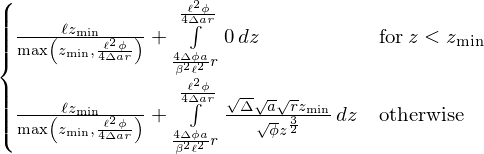

'demand without lightning'

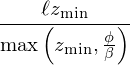

'withLightning'

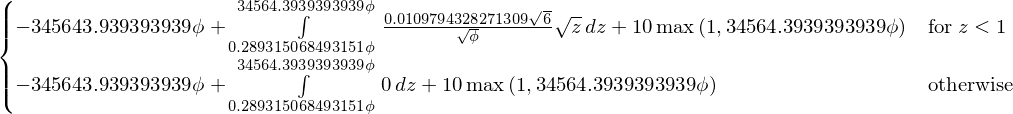

'withoutLightning'

'withLightning'

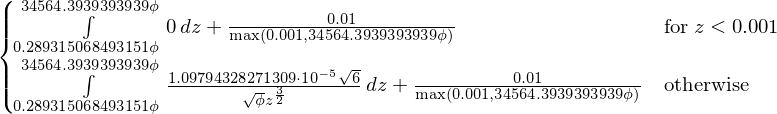

'withoutLightning'

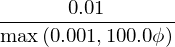

In [10]:
### Generic function for calculating demand - does not give plottable expressions:

def calculateDemands(optimal, valuePDF):
    demand = Result()
    demand.withLightning = simplified(
        sympy.integrate(a / optimal.T * valuePDF, (b, optimal.b12,optimal.b23)) +\
        sympy.integrate(L * valuePDF,             (b, optimal.b23,np.inf)),
        "demand with lightning"
    )
    demand.withoutLightning = simplified(
        sympy.integrate(L * valuePDF,             (b, optimal.b13,np.inf)),
        "demand without lightning"
    )
    numeric = demand.subs(params)
    return (demand,numeric)

simplified.LOG = True
asymmetricSymbolicUniform,asymmetricNumericUniform  = calculateDemands(asymmetricSymbolic, uniformPDF)
aymmetricSymbolicPowerlaw,asymmetricNumericPowerlaw = calculateDemands(asymmetricSymbolic, powerlawPDF)
asymmetricNumericUniform.display()
asymmetricNumericPowerlaw.display()

# Plots

In [1]:
plotSymmetric = True
plotAsymmetric = False

def plotSymbolic(xRange, yExpression, xVariable, style, label):
    plt.plot(xRange, [yExpression.subs(xVariable,xValue) for xValue in xRange], style, label=label)

def plotDemandCurves(priceRange, demandWithoutLightning, demandAsymmetric, demandSymmetric):
    global plotSymmetric, plotAsymmetric
    plotSymbolic(priceRange, demandWithoutLightning, p, "r-",label="no lightning")
    if plotAsymmetric:
        plotSymbolic(priceRange, demandAsymmetric, p,  "b.",label="asymmetric")
    if plotSymmetric:
        plotSymbolic(priceRange, demandSymmetric, p,  "g--",label="symmetric")
    plt.gca().set_ylim(-1,11)
    plt.xlabel("blockchain fee $\\phi$  [bitcoins]")
    plt.ylabel("Demand of a single pair [records/day]")
    plt.legend(loc=0)

def plotTxsCurves(priceRange, txsBlockchain, txsLightning):
    txsBlockchain = txsBlockchain.subs(params)
    txsLightning = txsLightning.subs(params)
    plotSymbolic(priceRange, txsBlockchain,  p,  "r--",label="blockchain")
    plotSymbolic(priceRange, txsLightning, p,  "b.",label="lightning")
    plotSymbolic(priceRange, txsLightning+txsBlockchain, p,  "k-",label="total")
    plt.gca().set_ylim(-1,11)
    plt.xlabel("blockchain fee $\\phi$  [bitcoins]")
    plt.ylabel("# Transactions per day")
    plt.legend(loc=0)

def plotPowerlawTxsCurves(priceRange, txsAsymmetric, txsSymmetric):
    global plotSymmetric, plotAsymmetric
    if plotAsymmetric:
        plotTxsCurves(priceRange, txsAsymmetric.txsBlockchainPowerlaw, txsAsymmetric.txsLightningPowerlaw)
        #plt.title("Transactions of a single asymmetric pair, power-law transfer-size")
    if plotSymmetric:
        plotTxsCurves(priceRange, txsSymmetric.txsBlockchainPowerlaw, txsSymmetric.txsLightningPowerlaw)
        #plt.title("Transactions of a single symmetric pair, power-law transfer-size")

def plotLifetimeCurves(priceRange, timeAsymmetric, timeSymmetric):
    global plotSymmetric, plotAsymmetric
    if plotAsymmetric:
        plotSymbolic(priceRange, timeAsymmetric, p,  "b.",label="asymmetric")
    if plotSymmetric:
        plotSymbolic(priceRange, timeSymmetric,  p,  "g--",label="symmetric")
    plt.xlabel("blockchain fee $\\phi$  [bitcoins]")
    plt.ylabel("Maximum channel lifetime [days]")
    plt.legend(loc=0)

def plotPriceCurves(nRange, priceWithoutLightning, priceAsymmetric, priceSymmetric):
    global plotSymmetric, plotAsymmetric
    priceWithoutLightning = priceWithoutLightning.subs(params)
    priceAsymmetric = priceAsymmetric.subs(params)
    priceSymmetric = priceSymmetric.subs(params)
    plotSymbolic(nRange, priceWithoutLightning, n, "r-",label="no lightning")
    if plotAsymmetric and priceAsymmetric:
        plotSymbolic(nRange, priceAsymmetric, n,  "b.",label="asymmetric")
    if plotSymmetric and priceSymmetric:
        plotSymbolic(nRange, priceSymmetric, n,  "g--",label="symmetric")
    plt.xlabel("Number of users $n$")
    plt.ylabel("Market-equilibrium price $\\phi$ [bitcoins/record]")
    plt.legend(loc=0)

def plotMarketTxsCurves(nRange, priceCurve, txsBlockchain, txsLightning):
    priceCurve = priceCurve.subs(params)
    txsBlockchain = txsBlockchain.subs(params)
    txsLightning = txsLightning.subs(params)
    plotSymbolic(nRange, n/2*txsBlockchain.subs(p,priceCurve), n,  "g--",label="blockchain")
    plotSymbolic(nRange, n/2*txsLightning.subs(p,priceCurve),  n,  "b." ,label="lightning")
    plotSymbolic(nRange, n/2*(txsLightning.subs(p,priceCurve)+txsBlockchain.subs(p,priceCurve)),  n,  "k-",label="total")
    plotSymbolic(nRange, Min(params[Supply], n*params[L]/2),  n, "r-", label="no lightning")
    plt.xlabel("Number of users $n$")
    plt.ylabel("# Transactions per day")
    plt.legend(loc=0)

def plotSymbolic3(xRange, yExpression, xVariable, style, label):
    plt.plot(xRange, [yExpression.subs(xVariable,xValue)*params[Supply] for xValue in xRange], style, label=label)
    
def plotRevenueCurves(nRange, priceWithoutLightning, priceAsymmetric, priceSymmetric):
    global plotSymmetric, plotAsymmetric
    plotSymbolic3(nRange, priceWithoutLightning, n, "r-",label="no lightning")
    if plotAsymmetric and priceAsymmetric:
        plotSymbolic3(nRange, priceAsymmetric, n,  "b.",label="asymmetric")
    if plotSymmetric and priceSymmetric:
        plotSymbolic3(nRange, priceSymmetric, n,  "g--",label="symmetric")
    plt.xlabel("Number of users $n$")
    plt.ylabel("Miners' revenue [bitcoins/day]")
    plt.legend(loc=0)    
    

## Power-law distribution

'demand without lightning'

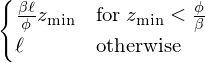

'demand with lightning'

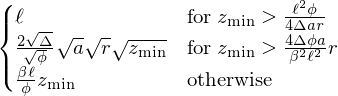

'txs lightning'

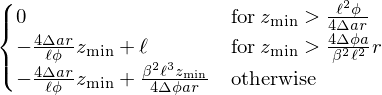

'txs blockchain'

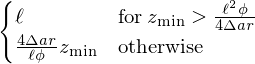

'demand without lightning'

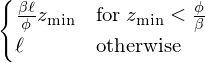

'demand with lightning'

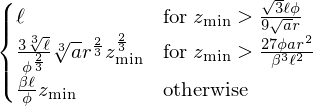

'txs lightning'

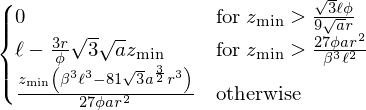

'txs blockchain'

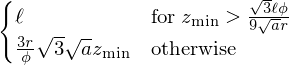

In [12]:
def calculateDemandsPowerlaw(optimal):
    optimal.demandB13 =   sympy.integrate(L * zmin / b**2,             (b, optimal.b13, np.inf))
    optimal.demandBzmin = sympy.integrate(L * zmin / b**2,             (b, zmin, np.inf))
    optimal.demandWithoutLightningPowerlaw = simplified(Piecewise(
        (optimal.demandB13,   zmin < optimal.b13),
        (optimal.demandBzmin, True)),
        "demand without lightning"
    )
    optimal.demandL1 = sympy.integrate(a / optimal.T * zmin / b**2, (b, optimal.b12, optimal.b23)) # zmin<b12<b23
    optimal.demandL2 = sympy.integrate(a / optimal.T * zmin / b**2, (b, zmin       , optimal.b23)) # b12<zmin<b23
    optimal.demandB1 = sympy.integrate(L * zmin / b**2, (b, optimal.b23, np.inf))      # zmin<b23
    optimal.demandB2 = sympy.integrate(L * zmin / b**2,             (b, zmin, np.inf))             # b12<b23<zmin
    optimal.demandWithLightningPowerlaw = simplified(Piecewise(
        (optimal.demandB2,                   optimal.b23 < zmin), 
        (optimal.demandL2+optimal.demandB1 , optimal.b12 < zmin),
        (optimal.demandL1+optimal.demandB1 , True),   
        ),
        "demand with lightning"
    )
    
    optimal.txsL1 = sympy.integrate(L * zmin / b**2, (b, optimal.b12, optimal.b23)) # zmin<b12<b23
    optimal.txsL2 = sympy.integrate(L * zmin / b**2, (b, zmin       , optimal.b23)) # b12<zmin<b23
    optimal.txsB1 = optimal.demandB1      # zmin<b23
    optimal.txsB2 = optimal.demandB2             # b12<b23<zmin
    optimal.txsLightningPowerlaw = simplified(Piecewise(
        (0,                   optimal.b23 < zmin), 
        (optimal.txsL2 , optimal.b12 < zmin),
        (optimal.txsL1 , True),   
        ),
        "txs lightning"
    )
    optimal.txsBlockchainPowerlaw = simplified(Piecewise(
        (optimal.demandB2,                   optimal.b23 < zmin), 
        (optimal.demandB1 , True),   
        ),
        "txs blockchain"
    )
    optimal.maxDemand1 = (optimal.demandB2).subs(p, 0)
    optimal.minDemand1 = (optimal.demandB2).subs(p, optimal.p23.subs(zmax,zmin) )
    optimal.maxDemand2 = (optimal.demandL2+optimal.demandB1).subs(p, optimal.p23.subs(zmax,zmin) )
    optimal.minDemand2 = (optimal.demandL2+optimal.demandB1).subs(p, optimal.p12.subs(zmax,zmin) )
    

def calculatePricesPowerlaw(optimal):
    price1 = simplified(solve((n/2)*(optimal.demandL2+optimal.demandB1)-Supply, p)[0])
    price2 = simplified(solve((n/2)*(optimal.demandL1+optimal.demandB1)-Supply, p)[0])

    optimal.priceWithLightningPowerlaw = simplified(Piecewise(
        (0,       (n/2) < Supply/optimal.minDemand1), 
        (price1 , (n/2) < Supply/optimal.minDemand2),       # = maxDemand1
        (price2, True)))
    return optimal
    
simplified.LOG = True

calculateDemandsPowerlaw(asymmetricSymbolic)
asymmetricNumeric = asymmetricSymbolic.subs(params)
calculateDemandsPowerlaw(symmetricSymbolic)
symmetricNumeric = symmetricSymbolic.subs(params)

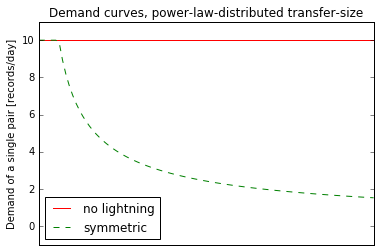

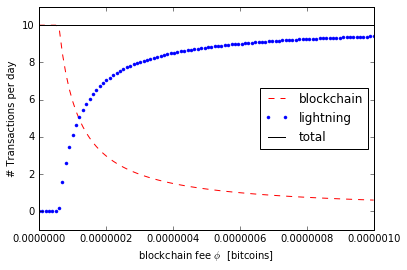

In [19]:
priceRange = np.linspace(0,1e-6,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightningPowerlaw, asymmetricNumeric.demandWithLightningPowerlaw, symmetricNumeric.demandWithLightningPowerlaw)
plt.title("Demand curves, power-law-distributed transfer-size")
plt.axes().get_xaxis().set_visible(False)
plt.savefig('../graphs/demand-curves-powerlaw-small-price.pdf', format='pdf', dpi=1000)
plt.show()
plotPowerlawTxsCurves(priceRange, asymmetricNumeric, symmetricNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-small-price.pdf', format='pdf', dpi=1000)    
plt.show()

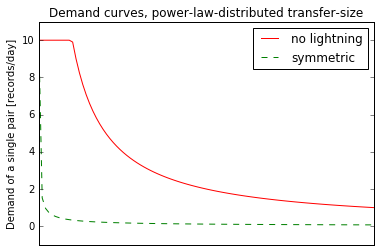

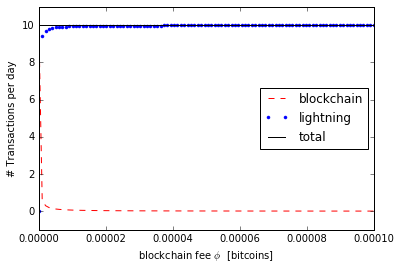

In [20]:
priceRange = np.linspace(0,1e-4,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightningPowerlaw, asymmetricNumeric.demandWithLightningPowerlaw, symmetricNumeric.demandWithLightningPowerlaw)
plt.title("Demand curves, power-law-distributed transfer-size")
plt.axes().get_xaxis().set_visible(False)
plt.savefig('../graphs/demand-curves-powerlaw-medium-price.pdf', format='pdf', dpi=1000)    
plt.show()
plotPowerlawTxsCurves(priceRange, asymmetricNumeric, symmetricNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-medium-price.pdf', format='pdf', dpi=1000)    
plt.show()

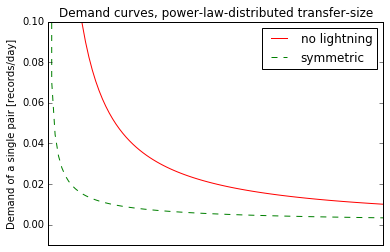

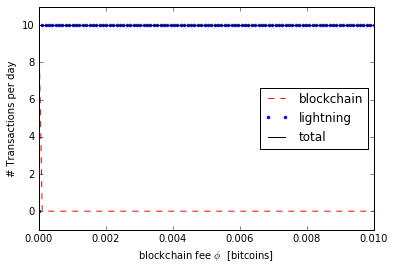

In [21]:
priceRange = np.linspace(0,0.01,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightningPowerlaw, asymmetricNumeric.demandWithLightningPowerlaw, symmetricNumeric.demandWithLightningPowerlaw)
plt.title("Demand curves, power-law-distributed transfer-size")
plt.gca().set_ylim(-0.01,0.1)
plt.axes().get_xaxis().set_visible(False)
plt.savefig('../graphs/demand-curves-powerlaw-large-price.pdf', format='pdf', dpi=1000)    
plt.show()
plotPowerlawTxsCurves(priceRange, asymmetricNumeric, symmetricNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-large-price.pdf', format='pdf', dpi=1000)    
plt.show()

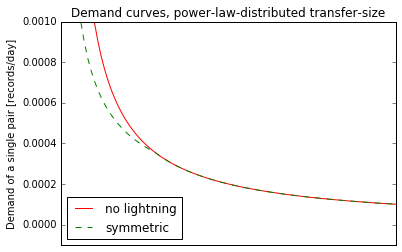

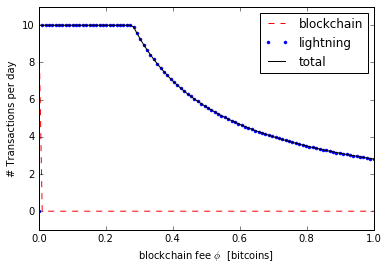

In [22]:
priceRange = np.linspace(0,1,100)
plotDemandCurves(priceRange, asymmetricNumeric.demandWithoutLightningPowerlaw, asymmetricNumeric.demandWithLightningPowerlaw, symmetricNumeric.demandWithLightningPowerlaw)
plt.title("Demand curves, power-law-distributed transfer-size")
plt.gca().set_ylim(-0.0001,0.001)
#plt.axes().get_xaxis().set_visible(False)
plt.savefig('../graphs/demand-curves-powerlaw-xlarge-price.pdf', format='pdf', dpi=1000)    
plt.show()
plotPowerlawTxsCurves(priceRange, asymmetricNumeric, symmetricNumeric)
plt.savefig('../graphs/txs-pair-powerlaw-xlarge-price.pdf', format='pdf', dpi=1000)    
plt.show()

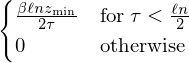

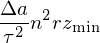

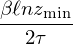

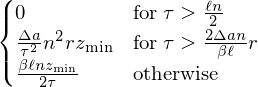

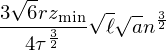

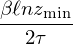

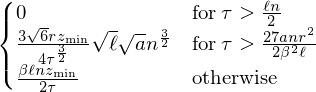

In [23]:
### Price curves - power-law distribution

priceWithoutLightningPowerlaw = simplified(Piecewise(
    ((n/2)*L*beta*zmin/Supply , (n/2)*L>Supply),
    (0,True)))

priceWithoutLightningPowerlaw = priceWithoutLightningPowerlaw.subs(params)

calculatePricesPowerlaw(asymmetricSymbolic)
asymmetricNumeric = asymmetricSymbolic.subs(params)
calculatePricesPowerlaw(symmetricSymbolic)
symmetricNumeric = symmetricSymbolic.subs(params)

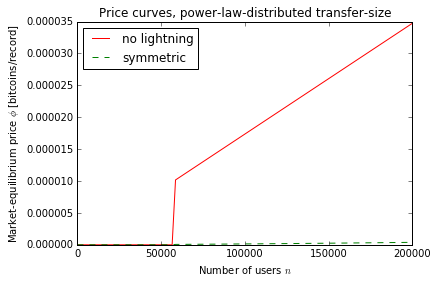

In [45]:
nRange = np.linspace(0,2e5,100)
plotPriceCurves(nRange, priceWithoutLightningPowerlaw, asymmetricNumeric.priceWithLightningPowerlaw, symmetricNumeric.priceWithLightningPowerlaw)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-smalln.pdf', format='pdf', dpi=1000)

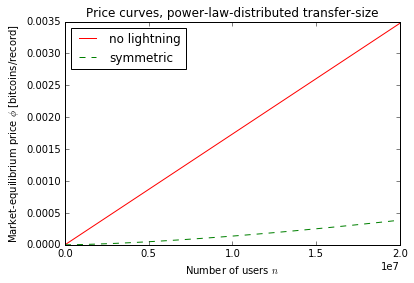

In [34]:
nRange = np.linspace(0,2e7,100)
plotPriceCurves(nRange, priceWithoutLightningPowerlaw, asymmetricNumeric.priceWithLightningPowerlaw, symmetricNumeric.priceWithLightningPowerlaw)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-mediumn.pdf', format='pdf', dpi=1000)

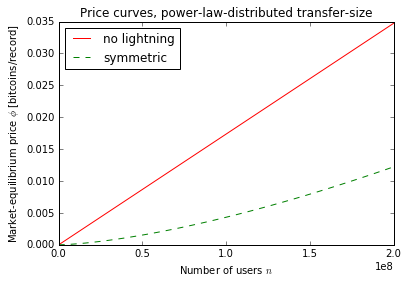

In [33]:
nRange = np.linspace(0,2e8,100)
plotPriceCurves(nRange, priceWithoutLightningPowerlaw, asymmetricNumeric.priceWithLightningPowerlaw, symmetricNumeric.priceWithLightningPowerlaw)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-largen.pdf', format='pdf', dpi=1000)

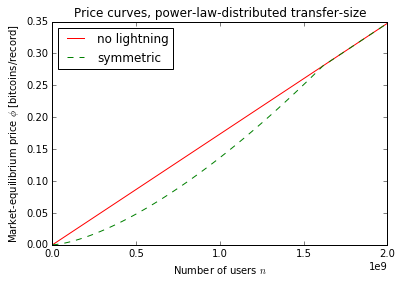

In [32]:
nRange = np.linspace(0,2e9,100)
plotPriceCurves(nRange, priceWithoutLightningPowerlaw, asymmetricNumeric.priceWithLightningPowerlaw, symmetricNumeric.priceWithLightningPowerlaw)
plt.title("Price curves, power-law-distributed transfer-size")
plt.savefig('../graphs/price-curves-powerlaw-hugen.pdf', format='pdf', dpi=1000)

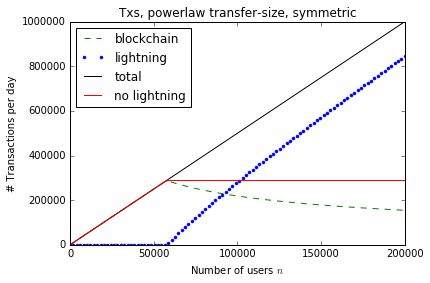

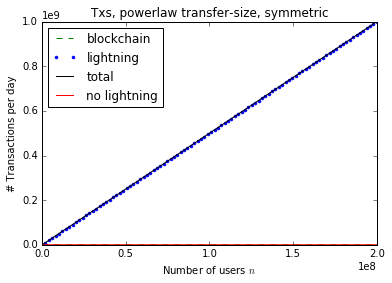

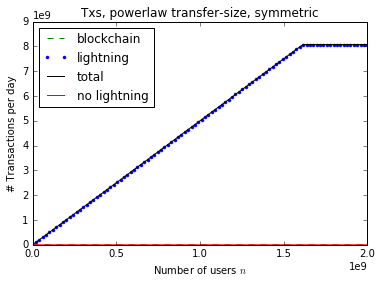

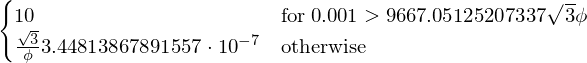

In [66]:
if plotAsymmetric:
    nRange = np.linspace(0,2e5,100)
    plotMarketTxsCurves(nRange, asymmetricNumeric.priceWithLightningPowerlaw, asymmetricNumeric.txsBlockchainPowerlaw, asymmetricNumeric.txsLightningPowerlaw)
    plt.title("Txs, powerlaw transfer-size, asymmetric")
    plt.savefig('../graphs/txs-market-powerlaw-asymmetric-smalln.pdf', format='pdf', dpi=1000)
    plt.show()
    nRange = np.linspace(0,2e8,100)
    plotMarketTxsCurves(nRange, asymmetricNumeric.priceWithLightningPowerlaw, asymmetricNumeric.txsBlockchainPowerlaw, asymmetricNumeric.txsLightningPowerlaw)
    plt.title("Txs, powerlaw transfer-size, asymmetric")
    plt.savefig('../graphs/txs-market-powerlaw-asymmetric-largen.pdf', format='pdf', dpi=1000)
    plt.show()
    nRange = np.linspace(0,2e9,100)
    plotMarketTxsCurves(nRange, asymmetricNumeric.priceWithLightningPowerlaw, asymmetricNumeric.txsBlockchainPowerlaw, asymmetricNumeric.txsLightningPowerlaw)
    plt.title("Txs, powerlaw transfer-size, asymmetric")
    plt.savefig('../graphs/txs-market-powerlaw-asymmetric-hugen.pdf', format='pdf', dpi=1000)
    plt.show()
if plotSymmetric:
    nRange = np.linspace(0,2e5,100)
    plotMarketTxsCurves(nRange, symmetricNumeric.priceWithLightningPowerlaw, symmetricNumeric.txsBlockchainPowerlaw, symmetricNumeric.txsLightningPowerlaw)
    plt.title("Txs, powerlaw transfer-size, symmetric")
    plt.savefig('../graphs/txs-market-powerlaw-symmetric-smalln.pdf', format='pdf', dpi=1000)
    plt.show()
    nRange = np.linspace(0,2e8,100)
    plotMarketTxsCurves(nRange, symmetricNumeric.priceWithLightningPowerlaw, symmetricNumeric.txsBlockchainPowerlaw, symmetricNumeric.txsLightningPowerlaw)
    plt.title("Txs, powerlaw transfer-size, symmetric")
    plt.savefig('../graphs/txs-market-powerlaw-symmetric-largen.pdf', format='pdf', dpi=1000)
    plt.show()
    nRange = np.linspace(0,2e9,100)
    plotMarketTxsCurves(nRange, symmetricNumeric.priceWithLightningPowerlaw, symmetricNumeric.txsBlockchainPowerlaw, symmetricNumeric.txsLightningPowerlaw)
    plt.title("Txs, powerlaw transfer-size, symmetric")
    plt.savefig('../graphs/txs-market-powerlaw-symmetric-hugen.pdf', format='pdf', dpi=1000)
    plt.show()
    
symmetricNumeric.txsBlockchainPowerlaw

(array([ 3146.,  1347.,   995.,   847.,   736.,   676.,   629.,   539.,
          544.,   541.]),
 array([  1.24167755e-08,   1.99935517e-01,   3.99871022e-01,
          5.99806527e-01,   7.99742032e-01,   9.99677536e-01,
          1.19961304e+00,   1.39954855e+00,   1.59948405e+00,
          1.79941956e+00,   1.99935506e+00]),
 <a list of 10 Patch objects>)

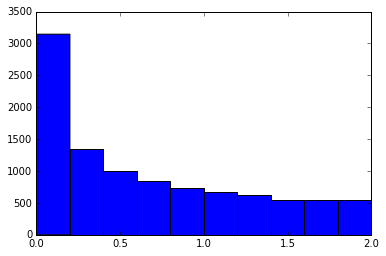

In [37]:
pw=np.random.power(a=0.5,size=10000)*2
plt.hist(pw)

In [42]:
def first10():
    for i in range(10):
        yield i
        
first10.__len__ = lambda self: 10

for i in first10():
    print(i)
    
print(len(first10))

0
1
2
3
4
5
6
7
8
9


TypeError: object of type 'function' has no len()